<a href="https://colab.research.google.com/github/maddysshaw/Cognitive_AI_2024/blob/main/Coursework2d_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2(d)
These marks are reserved for something original. Some possibilities could be
training networks with a totally different architecture, implementing a different
type of learning (e.g. reinforcement), implementing neuromodulation, training
on multiple tasks at once, or many tasks or anything else unexpected. Anything
presented in this section should be done so in comparison with what you know
about how brains and standard ML/AI models learn. This part is only worth 20%
of the coursework marks [10% of total], so please do not spend a
disproportionate amount of time on it. [20]

In [26]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns

# Excitatory - Inhibitory Model

In [27]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math

class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag = torch.ones(hidden_size, hidden_size) - torch.eye(hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        exc = np.ones(self.e_size)
        inh = -np.ones(self.i_size)
        E_I_unit_list = np.concatenate((exc, inh)).T

        mask = mask_no_diag * E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, output_size, dt=None,
                 e_prop=0.8, sigma_rec=0, gamma=0.9, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size  # Store output_size

        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

        self.value_function = nn.Linear(hidden_size, output_size)
        self.gamma = gamma  # Discount factor

    # def __init__(self, input_size, hidden_size, output_size, e_prop=0.8, gamma=0.9, **kwargs):
    #     super().__init__()
    #     #self.eirnn = EIRNN(input_size, hidden_size, e_prop=e_prop, **kwargs)
    #     self.input_size = input_size
    #     self.hidden_size = hidden_size
    #     self.output_size = output_size  # Store output_size
    #     self.e_size = int(hidden_size * e_prop)
    #     self.i_size = hidden_size - self.e_size

    #     self.input2h = nn.Linear(input_size, hidden_size)
    #     self.h2h = EIRecLinear(hidden_size, e_prop=e_prop) # Call EIRecLinear with e_prop
    #     self.value_function = nn.Linear(hidden_size, output_size)
    #     self.gamma = gamma  # Discount factor

    # def forward(self, state):
    #     # # Pass the state through the RNN and estimate the value
    #     # _, hidden_states = self.eirnn(state.unsqueeze(0))
    #     # values = self.value_function(hidden_states[1])  # Use the output state
    #     # return values
    #     """Propogate input through the network."""
    #     # Initialize hidden state if not provided
    #     hidden = self.init_hidden(state)

    #     # Prepare output list to store hidden states
    #     output = []

    #     # Iterate through time steps (assuming state is a sequence)
    #     steps = range(state.size(0))
    #     for i in steps:
    #         # Update hidden state using recurrence relation
    #         hidden = self.recurrence(state[i], hidden)
    #         # Append the output (hidden[1]) to the list
    #         output.append(hidden[1])

    #     # Stack the output into a tensor
    #     output = torch.stack(output, dim=0)
    #     return output, hidden

    def init_hidden(self, input):
        batch_size = input.shape[0] if input.dim() == 1 else input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

        print(f"Hidden type: {type(hidden)}, Hidden content: {hidden}")
        print(f"State type: {type(state)}, State content: {state}")
        print(f"Output type: {type(output)}, Output content: {output}")

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class EINet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, output_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [28]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


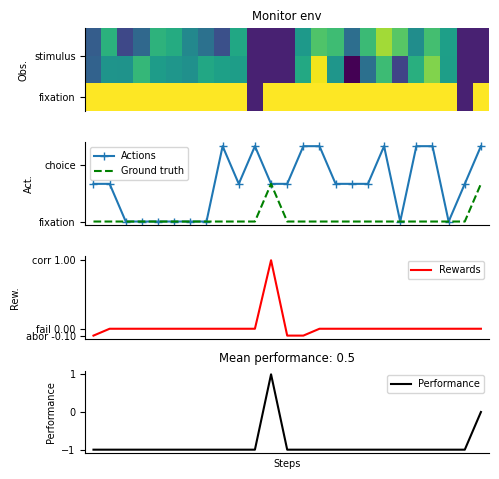

In [29]:
import neurogym as ngym
from neurogym.wrappers.monitor import Monitor


import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
env = Monitor(env)  # Wrap the task for compatibility with RL

# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [30]:
# @title Reinforcement Learning Implementation

import torch
import torch.nn as nn
import torch.optim as optim

class EI_RNN_Agent(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, e_prop=0.8, gamma=0.99):
        super().__init__()
        self.eirnn = EIRNN(input_size, hidden_size, output_size, e_prop=e_prop)
        self.policy_head = nn.Linear(hidden_size, output_size)  # Action probabilities
        self.value_head = nn.Linear(hidden_size, 1)  # Value function for advantage-based methods
        self.gamma = gamma  # Discount factor

    def forward(self, input, hidden=None):
        rnn_output, hidden = self.eirnn(input, hidden)
        policy = nn.functional.softmax(self.policy_head(rnn_output[-1]), dim=-1)
        value = self.value_head(rnn_output[-1])  # Optional: for advantage-based methods
        return policy, value, hidden

    def decide(self, policy):
        #if policy.dim() > 1:
        #print(f"Policy shape before squeeze: {policy.shape}")
        policy = policy.squeeze(0)  # Remove batch dimension if present
        #print(f"Policy shape after squeeze: {policy.shape}")
        # Check if policy is valid
        if policy.dim() != 1:
            raise ValueError(f"Policy tensor must be 1D, but got shape {policy.shape}")
        if not torch.isclose(policy.sum(), torch.tensor(1.0)):
            raise ValueError(f"Policy probabilities must sum to 1, but got {policy.sum().item()}")


        # Sample an action based on the probabilities

        action = torch.multinomial(policy, 1).item()
        return action.squeeze(1)  # Remove the extra dimension

# # Example policy tensor
# policy = torch.tensor([[0.1, 0.7, 0.2]])  # A 2D tensor (batch of size 1)

# # Ensure `decide` works
# agent = EI_RNN_Agent(input_size=10, hidden_size=128, output_size=3)  # Example agent
# action = agent.decide(policy)

# print(f"Sampled action: {action}")
# print(f"Policy shape: {policy.shape}, Policy values: {policy}")
# policy = torch.tensor([[0.2, 0.5, 0.3]])  # 2D
# action = agent.decide(policy)
# print(f"Sampled action: {action}")
# Forward pass in your training loop

output, activity = EINet(inputs)
output = output.view(-1, 3)  # Assuming output is of shape [batch_size, 3] (for 3 possible actions)

# Convert output to probabilities
policy = F.softmax(output, dim=-1)  # Apply softmax to get a probability distribution

# For a single sample:
action = agent.decide(policy[i])  # Where `i` is the index in the batch (for batch_size > 1)





TypeError: EINet.__init__() missing 2 required positional arguments: 'hidden_size' and 'output_size'

In [32]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Lists to store the losses
EI_loss_values = []  # To store the classification loss (EI loss)
RL_loss_values = []  # To store the reinforcement learning loss (reward)
total_loss_values = []  # To store the total loss (EI loss + RL loss)

EI_running_loss = 0.0
RL_running_loss = 0.0
total_running_loss = 0.0
print_step = 100

# Training loop
for i in range(2500):
    inputs, labels = dataset()  # Get input data and ground truth labels (0 or 1)
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass through the network to get the policy (decision probabilities)
    output, activity = EI_net(inputs)  # This output should represent the policy for the decision
    output = output.view(-1, output_size)

    # Convert output to probabilities (e.g., using softmax for classification)
    policy = F.softmax(output, dim=-1)  # Apply softmax to get a probability distribution

    # Sample an action (0 or 1) from the policy
    #action = agent.decide(policy)
    actions = []
    for j in range(policy.shape[0]):
        action = agent.decide(policy[j])
        actions.append(action)
    actions = torch.tensor(actions)


    rewards = torch.where(actions == labels, torch.tensor(0.01), torch.tensor(-0.01))

    # # Compute the reward: Correct decision (reward = 10) or wrong decision (penalty = -10)
    # if action == labels.item():  # Compare the predicted action with the true label
    #     reward = 10
    # else:
    #     reward = -10

    # Compute the cross-entropy loss (classification loss)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, labels)

     # Compute the RL loss (which is the reward)
    RL_loss = -rewards.mean()  # The RL loss is negative to reward correct actions

    # Combine the classification loss with the reward to maximize both accuracy and reward
    total_loss = loss + RL_loss  # You can adjust the weight of the reward here if necessary

    # Backward pass
    total_loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    EI_running_loss += loss.item()
    RL_running_loss += RL_loss.item()
    total_running_loss += total_loss.item()

    if i % print_step == (print_step - 1):
        average_EI_loss = EI_running_loss / print_step
        average_RL_loss = RL_running_loss / print_step
        average_total_loss = total_running_loss / print_step
        print(f'Step {i+1}, EI Loss: {average_EI_loss:0.4f}, RL Loss: {average_RL_loss:0.4f}, Total Loss: {average_total_loss:0.4f}')
        RL_loss_values.append(average_RL_loss)
        EI_loss_values.append(average_loss)
        total_loss_values.append(average_total_loss)

        # reset for next period
        EI_running_loss = 0.0
        RL_running_loss = 0.0
        total_running_loss = 0.0

# Plotting the losses
plt.figure(figsize=(10, 5))

# # Plotting the EI Loss (classification loss)
# plt.plot(EI_loss_values, label='EI Loss', color='blue')

# Plotting the RL Loss (reinforcement learning loss)
plt.plot(RL_loss_values, label='RL Loss', color='red')

# Plotting the Total Loss (combined loss)
plt.plot(total_loss_values, label='Total Loss', color='green')

# Adding labels and legend
plt.title('Training Losses')
plt.xlabel('Training Steps')
plt.ylabel('Loss Value')
plt.legend()

# Show the plot
plt.show()

# Plotting the EI Loss (classification loss)
plt.plot(EI_loss_values, label='EI Loss', color='blue')
plt.title('EI Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

NameError: name 'optimizer' is not defined

In [24]:

# Plotting the losses
#plt.figure(figsize=(10, 5))

# # Plotting the EI Loss (classification loss)
# plt.plot(EI_loss_values, label='EI Loss', color='blue')

# Plotting the Total Loss (combined loss)
plt.plot(total_loss_values, label='Total Loss', color='green')

# Adding labels and legend
plt.title('Training Losses')
plt.xlabel('Training Steps')
plt.ylabel('Loss Value')
plt.legend()

# Show the plot
plt.show()

# Plotting the EI Loss (classification loss)
plt.plot(EI_loss_values, label='EI Loss', color='blue')
plt.title('EI Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Plotting the RL Loss (reinforcement learning loss)
plt.plot(RL_loss_values, label='RL Loss', color='red')
plt.title('RL Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

NameError: name 'total_loss_values' is not defined

In [8]:
def record_neural_activity(model, env, title_suffix=''):
    perf = 0
    num_trial = 500
    activity_dict = {}
    trial_infos = {}
    stim_activity = [[], []]  # response for ground-truth 0 and 1

    for i in range(num_trial):
        # Initialize a new trial
        env.new_trial()
        ob, gt = env.ob, env.gt

        # Convert the input to a tensor
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

        # Forward pass through the model to get predictions and hidden layer activations
        action_pred, rnn_activity = model(inputs)

        # Compute performance: Correct vs Incorrect choice
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial information
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Log neural activity (hidden layer) during this trial
        # Assuming rnn_activity contains the hidden states or neural activity
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()  # Ensure it’s a numpy array
        activity_dict[i] = rnn_activity

        # Compute stimulus selectivity for all units
        rnn_activity_stimulus = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]

        # Log stimulus activity based on the ground truth
        stim_activity[env.trial['ground_truth']].append(rnn_activity_stimulus)

    # Print the average performance across all trials
    avg_perf = np.mean([val['correct'] for val in trial_infos.values()])
    print(f'Average performance of {title_suffix}: {avg_perf}')

    # Return all relevant information
    return rnn_activity, action_pred, trial_infos, activity_dict, stim_activity


<ipython-input-2-62f6eaed036b>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Average performance of Hybrid Learning Model: 0.506


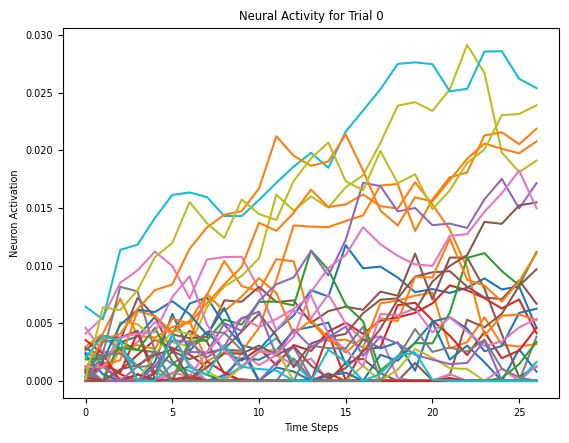

In [10]:
# Define your parameters (adjust these based on your model setup)
hidden_size = 50
output_size = 2  # Assuming binary classification, 0 or 1 as the output
dt = 0.01  # Adjust based on your environment setup

# Instantiate the EINet model
EI_Net = EINet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=dt, sigma_rec=0.15)

# After running the model and recording activity
rnn_activity, action_pred, trial_infos, activity_dict, stim_activity = record_neural_activity(EI_Net, env, title_suffix='Hybrid Learning Model')

# Example: Plot neural activity for the first trial
import matplotlib.pyplot as plt

# Plot the neural activity for trial 0
trial_0_activity = activity_dict[0]  # Neural activity from the first trial
plt.plot(trial_0_activity)
plt.title("Neural Activity for Trial 0")
plt.xlabel("Time Steps")
plt.ylabel("Neuron Activation")
plt.show()

# You can also compute and plot the average activity or compare activity across trials


Text(0, 0.5, 'Activity')

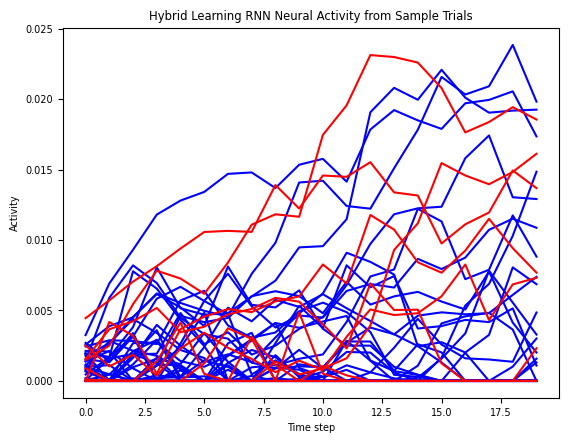

In [35]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = EI_Net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.title('Hybrid Learning RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [17]:
# @title Compute Stimulus Selectivity for sorting neurons
# Here for each neuron we compute its stimulus period selectivity

def compute_selectivity(model, activity_dict, trial_infos, stim_activity):
  if model == EI_Net:
    input_size = EI_Net.rnn.e_size
  else:
    input_size = model.rnn.input_size
  #input_size = model.rnn.input_size
  #fa_input_size = fa_net.rnn.input_size
  #input_size = net.rnn.input_size

  mean_activity = []
  std_activity = []
  for ground_truth in [0, 1]:
      activity = np.concatenate(stim_activity[ground_truth], axis=0)
      mean_activity.append(np.mean(activity, axis=0))
      std_activity.append(np.std(activity, axis=0))

  # Compute d'
  selectivity = (mean_activity[0] - mean_activity[1])
  selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

  if model == EI_Net:
  # Sort index for selectivity, separately for E and I
    ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                               np.argsort(selectivity[e_size:])+e_size))
  else:
    ind_sort = np.argsort(selectivity)

  return selectivity, ind_sort

selectivity, ind_sort = compute_selectivity(EI_Net, activity_dict, trial_infos, stim_activity)

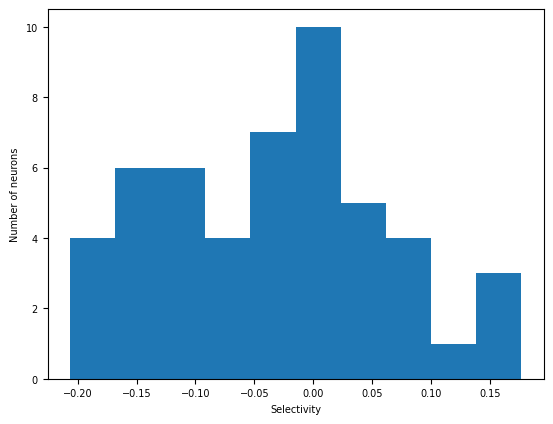

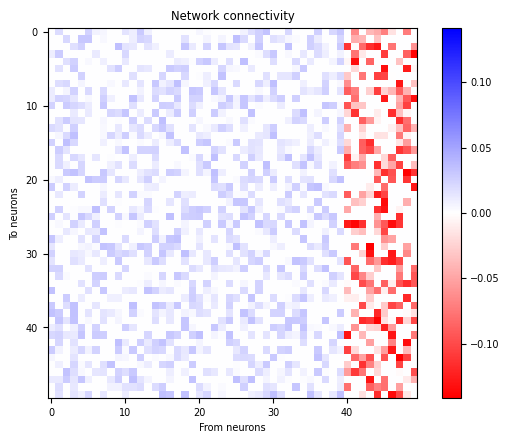

In [18]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def plot_connectivity(model, selectivity):
  # Plot distribution of stimulus selectivity
  plt.figure()
  plt.hist(selectivity)
  plt.xlabel('Selectivity')
  plt.ylabel('Number of neurons')

  if model == EI_Net:
    W = model.rnn.h2h.effective_weight().detach().numpy()
  else:
    W = model.rnn.h2h.weight.detach().numpy()
  # Sort by selectivity
  W = W[:, ind_sort][ind_sort, :]
  wlim = np.max(np.abs(W))
  plt.figure()
  plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
  plt.colorbar()
  plt.xlabel('From neurons')
  plt.ylabel('To neurons')
  plt.title('Network connectivity')
plot_connectivity(EI_Net, selectivity)

In [22]:
# @title Lesioning the Network

import torch.optim as optim

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2  # Example: Lesion top 20% of neurons

def lesion_network(model, selectivity):
  if model == EI_Net:
    input_size = model.rnn.e_size
  else:
    input_size = model.rnn.input_size
  num_neurons_to_lesion = int(lesion_fraction * input_size)  # Lesion top 20% most selective neurons
  selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

  # Lesion function: Set weights to zero for selected neurons
  #def lesion_network(net, selective_neurons):
  with torch.no_grad():  # Ensure no gradients are recorded for this modification
          # Set input and output weights of the selected neurons to zero
          model.rnn.h2h.weight[:, selective_neurons] = 0
          model.rnn.h2h.weight[selective_neurons, :] = 0

  # Save initial weights for resetting after experiment
  initial_weights = model.rnn.h2h.weight.clone()

  # Lesion the network
  #lesion_network(model, selective_neurons)

  # Re-run the training/evaluation to observe the impact of lesioning on performance
  loss_values_lesioned = []  # List to store loss values post-lesioning
  running_loss_lesioned = 0.0

  print('Evaluating network after lesioning top 20% of neurons...')
  for i in range(300):  # Fewer steps to evaluate effect
      inputs, labels = dataset()
      inputs = torch.from_numpy(inputs).type(torch.float)
      labels = torch.from_numpy(labels.flatten()).type(torch.long)

      # Zero the gradient buffers
      optimizer.zero_grad()

      # Forward pass
      output, activity = model(inputs)
      output = output.view(-1, output_size)

      # Compute loss
      loss = criterion(output, labels)

      # Compute the RL loss (which is the reward)
      RL_loss = -rewards.mean()  # The RL loss is negative to reward correct actions

      # Combine the classification loss with the reward to maximize both accuracy and reward
      total_loss = loss + RL_loss  # You can adjust the weight of the reward here if necessary

      # Backward pass
      total_loss.backward()

      # Update weights
      optimizer.step()

      # Update running loss
      EI_running_loss += loss.item()
      RL_running_loss += RL_loss.item()
      total_running_loss += total_loss.item()

      if i % print_step == (print_step - 1):
          average_EI_loss = EI_running_loss / print_step
          average_RL_loss = RL_running_loss / print_step
          average_total_loss = total_running_loss / print_step
          print(f'Step {i+1}, EI Loss: {average_EI_loss:0.4f}, RL Loss: {average_RL_loss:0.4f}, Total Loss: {average_total_loss:0.4f}')
          RL_loss_values.append(average_RL_loss)
          EI_loss_values.append(average_loss)
          total_loss_values.append(average_total_loss)

          # reset for next period
          EI_running_loss = 0.0
          RL_running_loss = 0.0
          total_running_loss = 0.0

      # Update running loss
      running_loss_lesioned += loss.item()
      if i % print_step == (print_step - 1):
          average_loss = running_loss_lesioned / print_step
          print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
          loss_values_lesioned.append(average_loss)  # Append average loss here
          running_loss_lesioned = 0.0

  # Reset weights after lesioning to original state
  EINet.rnn.h2h.weight = nn.Parameter(initial_weights)

lesion_network(EI_Net, selectivity)

Evaluating network after lesioning top 20% of neurons...


NameError: name 'optimizer' is not defined

Performing PCA for the Hybrid Learning Model...
Shape of the neural activity (Time points, Neurons) for Hybrid Learning Model: (16717, 50)
Shape of the projected activity (Time points, PCs) for Hybrid Learning Model: (16717, 2)
Explained variance by first 2 PCs: [0.08777873 0.03502071]


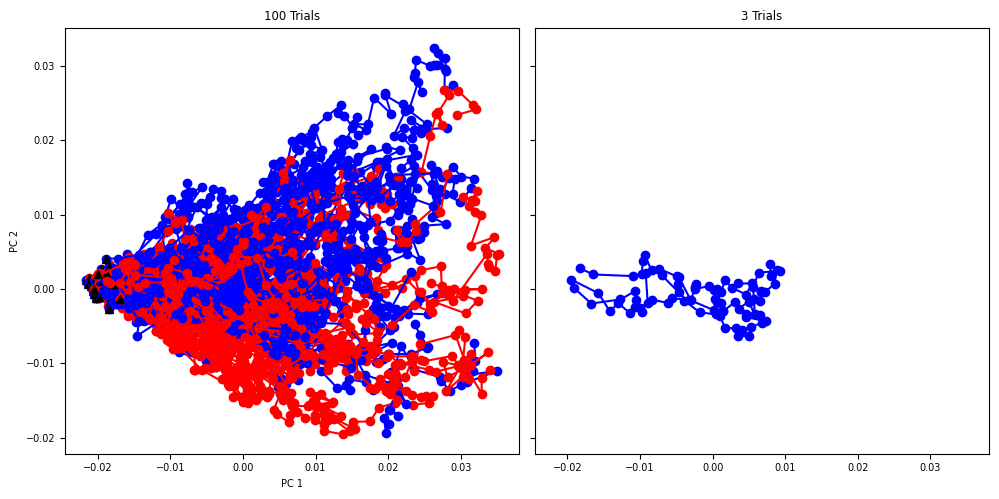

In [23]:
# @title Performing PCA
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 100


def pca_analysis(activity_dict, trial_infos, title_suffix=''):
  # Concatenate activity data across all trials for PCA
  activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
  # print('Shape of the neural activity (Time points, Neurons):', activity.shape)
  print(f'Shape of the neural activity (Time points, Neurons) for {title_suffix}:', activity.shape)

  # Initialize PCA and fit it on the activity data
  pca = PCA(2)  # Using 2 components for visualization
  pca.fit(activity)
  activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
  print(f'Shape of the projected activity (Time points, PCs) for {title_suffix}:', activity_pc.shape)

  # Visualization
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

  # Plot all trials in ax1 and fewer trials in ax2 for clarity
  for i in range(100):
      # Transform and plot each trial
      activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

      # Color by ground truth
      trial = trial_infos[i]
      color = 'red' if trial['ground_truth'] == 0 else 'blue'

      ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
      if i < 3:  # Fewer trials in ax2 for clear visualization
          ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

      # Indicate trial start with a different marker
      ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

  explained_variance = pca.explained_variance_ratio_
  print(f"Explained variance by first 2 PCs: {explained_variance[:2]}")

  # Setting labels and titles for clarity
  ax1.set_title('100 Trials')
  ax2.set_title('3 Trials')
  ax1.set_xlabel('PC 1')
  ax1.set_ylabel('PC 2')

  plt.tight_layout()
  plt.show()

print("Performing PCA for the Hybrid Learning Model...")
pca_analysis(activity_dict, trial_infos, title_suffix='Hybrid Learning Model')


In [47]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
hidden_size = 50
learning_rate = 0.001
gamma = 0.99  # Discount factor for RL (could be 0 for simple RL)
num_episodes = 5000
reward_for_correct = 1
penalty_for_incorrect = -1

# Instantiate the EI network
EI_net = EINet(input_size=input_size, hidden_size=hidden_size,
               output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(EI_net)

# Use Adam optimizer
optimizer = optim.Adam(EI_net.parameters(), lr=learning_rate)

# Loss functions
cross_entropy_loss = nn.CrossEntropyLoss()

# Placeholder for logging
rewards_history = []
loss_history = []

# Training loop
for episode in range(num_episodes):
    # Generate data for one episode
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)
    print(labels)

    log_probs = []  # Store log probabilities for each step
    rewards = []    # Store rewards for each step
    accuracy_loss = 0  # Initialize accuracy loss for the episode

    # Run the episode
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        # Forward pass
        policy, _ = EI_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))

        # Select an action based on the policy (softmax over logits)
        probs = torch.softmax(policy.squeeze(0), dim=-1)
        current_probs = probs[0]
        #action = torch.multinomial(current_probs, 1).item()
        action = torch.multinomial(policy.squeeze(0), 1).item()

        # Get the log probability of the action taken
        log_prob = torch.log(probs[action])
        log_probs.append(log_prob)

        # action = torch.tensor(action)  # Ensure action is a tensor
        # #label = labels.item()  # Convert label to a scalar for comparison
        # # Compute the reward (simple correct/incorrect for now)
        # if action == labels:  # Can try and chnage the condition
        #     reward = 10
        # else:
        #     reward = -20

        for i in range(len(action)):
            if action[i] == labels[i]:
                reward = 10  # Correct action
            else:
                reward = -10  # Incorrect action
            rewards.append(reward)  # Store the reward for this timestep

        rewards.append(reward)
        total_reward += reward

        # Take the action in the environment (feedback loop)
        next_state, _, done, _ = env.step(action)
        state = next_state

    # Compute discounted rewards
    discounted_rewards = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)

    # Normalize rewards
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
    if len(discounted_rewards) > 1:
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    # Compute the accuracy (supervised loss) part
    output, activity = EI_net(inputs)
    output = output.view(-1, output_size)
    supervised_loss = cross_entropy_loss(output, labels)

    # Compute the RL loss (policy gradient)
    rl_loss = 0
    for log_prob, reward in zip(log_probs, discounted_rewards):
        rl_loss += -log_prob * reward

    # Total loss (combining supervised and RL loss)
    total_loss = supervised_loss + rl_loss  # You can scale these losses if needed

    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Logging
    rewards_history.append(total_reward)
    loss_history.append(total_loss.item())
    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Loss: {total_loss.item()}")

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.title("EI-RNN Hybrid Training (Supervised + RL)")
plt.plot(rewards_history, label="Total Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()


EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
    (value_function): Linear(in_features=50, out_features=3, bias=True)
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
tensor([0, 0, 1,  ..., 0, 0, 0])


<ipython-input-31-62f6eaed036b>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [27]:

# Initialize agent, optimizer, and hyperparameters
input_size = env.observation_space.shape[0]
hidden_size = 128
output_size = env.action_space.n
agent = EI_RNN_Agent(input_size, hidden_size, output_size)

optimizer = optim.Adam(agent.parameters(), lr=0.001)
gamma = 0.99  # Discount factor

num_episodes = 1000
max_timesteps = 100

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dim

    log_probs = []
    rewards = []
    values = []  # Optional: for advantage-based methods
    hidden = None

    for t in range(max_timesteps):
        # Forward pass: get policy and value (optional)
        policy, value, hidden = agent(state, hidden)

        # Select action
        action = agent.decide(policy[0])
        log_prob = torch.log(policy.squeeze(0)[action])
        log_probs.append(log_prob)
        values.append(value)

        # Step the environment
        next_state, reward, done, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        # Record reward
        rewards.append(reward)

        # Transition to next state
        state = next_state

        if done:
            break

    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)

    # Compute loss
    log_probs = torch.stack(log_probs)
    values = torch.cat(values).squeeze()
    advantages = returns - values  # For actor-critic

    policy_loss = -(log_probs * advantages.detach()).mean()
    value_loss = advantages.pow(2).mean()  # Optional: for actor-critic
    loss = policy_loss + value_loss

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log progress
    if episode % 50 == 0:
        print(f"Episode {episode}/{num_episodes}, Total Reward: {sum(rewards)}")


<ipython-input-8-496903e329dc>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


RuntimeError: The size of tensor a (100) must match the size of tensor b (300) at non-singleton dimension 0